<a href="https://colab.research.google.com/github/kkalera/FastAI-Image-Classifier/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook shows how one can make an image classifier using the FastAI library. 

This notebook will cover:
- Installing the library
- Getting image data
- Training a model
- Observing the results

In [ ]:
# Installing libraries:
# -Uqq means quiet installation
# fastai = fastai library for creating and training models
# duckduckgo_search = Library which allows us to use the search engine duckduckgo. Will be used to gather our data
!pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 96 kB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


---
# Getting data:
Instead of getting a premade dataset like a lot of tutorials use, we will gather a custom dataset by searching for images on duckduckgo.

We will write a couple of helper functions to do this

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import *
from fastai.vision.all import *
from time import sleep

def search_images(term, max_images=30):
  '''
    Uses the DuckDuckGo search engine to search for images of the provided term

    Parameters:
            term (string): The search term to use
            max_images (int): The amount of images to search
    Returns:
            (list): List of URL's of the images found
  '''
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

def download_data(categories, path, img_per_cat):
  for category in categories:
    destination = path/category
    destination.mkdir(exist_ok=True, parents=True)
    download_images(destination, urls=search_images(f"{category} photo", img_per_cat))
    resize_images(path/category, max_size=400, dest=path/category)
    sleep(10)
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)
    print(f'{len(failed)} images of {category} failed to download.')

Defining our categories and downloading the data:

In [ ]:
categories = ['Dog', 'Giraffe']
path = Path("classifier")
download_data(categories,path, 30)

Searching for 'Dog photo'
0 images of Dog failed to download.
Searching for 'Giraffe photo'
1 images of Giraffe failed to download.


Creating the datablock.

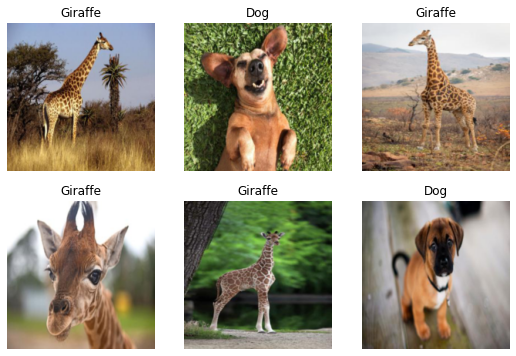

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

# Training the model

In [ ]:
model = vision_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.132999,6.182398,0.545455,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.511694,4.036634,0.545455,00:07
1,1.228970,2.138432,0.454545,00:06
2,0.919528,0.871627,0.363636,00:07
3,0.723239,0.247080,0.181818,00:08
4,0.574526,0.045862,0.000000,00:07
5,0.474305,0.016582,0.000000,00:07
6,0.402714,0.007355,0.000000,00:07
7,0.348823,0.004570,0.000000,00:07
8,0.307594,0.003597,0.000000,00:07
9,0.274535,0.003607,0.000000,00:07


# Observing the results:

This is a Giraffe. Probability: 0.6968


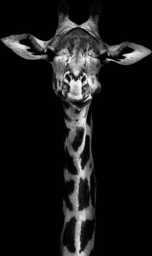

In [ ]:
def predict(model, url):
  download_url(url, 'test_img.jpg', show_progress=False)  
  category,_,probability = model.predict(PILImage.create('test_img.jpg'))
  print(f'This is a {category}. Probability: {probability.max():.4f}')

predict(model, 'https://media.s-bol.com/x2E8EkXDQ5rq/711x1200.jpg')
Image.open('test_img.jpg').to_thumb(256,256)